In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:
class BoneType:
    HEAD = "HEAD"
    TORSO = "TORSO"
    LEFT_UP_ARM = "LEFT_UP_ARM"
    LEFT_DOWN_ARM = "LEFT_DOWN_ARM"
    RIGHT_UP_ARM = "RIGHT_UP_ARM"
    RIGHT_DOWN_ARM = "RIGHT_DOWN_ARM"
    LEFT_UP_LEG = "LEFT_UP_LEG"
    LEFT_DOWN_LEG = "LEFT_DOWN_LEG"
    RIGHT_UP_LEG = "RIGHT_UP_LEG"
    RIGHT_DOWN_LEG = "RIGHT_DOWN_LEG"
    
class JointType:
    HEAD = 0
    NECK = 1
    LEFT_SHOULDER = 2
    RIGHT_SHOULDER = 3
    LEFT_ELBOW = 4
    RIGHT_ELBOW = 5
    LEFT_HAND = 6
    RIGHT_HAND = 7
    TORSO = 8
    LEFT_HIP = 9
    RIGHT_HIP = 10
    LEFT_KNEE = 11
    RIGHT_KNEE = 12
    LEFT_FOOT = 13
    RIGHT_FOOT = 14
    
joint_pairs = {}
joint_pairs[BoneType.HEAD] = [
    (JointType.HEAD, JointType.NECK)
]
joint_pairs[BoneType.TORSO] = [
    (JointType.NECK, JointType.LEFT_SHOULDER),
    (JointType.NECK, JointType.RIGHT_SHOULDER),
    (JointType.NECK, JointType.TORSO),
    (JointType.TORSO, JointType.LEFT_SHOULDER),
    (JointType.TORSO, JointType.RIGHT_SHOULDER),
    (JointType.TORSO, JointType.LEFT_HIP),
    (JointType.TORSO, JointType.RIGHT_HIP),
    (JointType.LEFT_SHOULDER, JointType.LEFT_HIP),
    (JointType.RIGHT_SHOULDER, JointType.RIGHT_HIP),
    (JointType.LEFT_HIP, JointType.RIGHT_HIP),
]
joint_pairs[BoneType.LEFT_UP_ARM] = [
    (JointType.LEFT_SHOULDER, JointType.LEFT_ELBOW)
]
joint_pairs[BoneType.LEFT_DOWN_ARM] = [
    (JointType.LEFT_ELBOW, JointType.LEFT_HAND)
]
joint_pairs[BoneType.RIGHT_UP_ARM] = [
    (JointType.RIGHT_SHOULDER, JointType.RIGHT_ELBOW)
]
joint_pairs[BoneType.RIGHT_DOWN_ARM] = [
    (JointType.RIGHT_ELBOW, JointType.RIGHT_HAND)
]
joint_pairs[BoneType.LEFT_UP_LEG] = [
    (JointType.LEFT_HIP, JointType.LEFT_KNEE)
]
joint_pairs[BoneType.LEFT_DOWN_LEG] = [
    (JointType.LEFT_KNEE, JointType.LEFT_FOOT)
]
joint_pairs[BoneType.RIGHT_UP_LEG] = [
    (JointType.RIGHT_HIP, JointType.RIGHT_KNEE)
]
joint_pairs[BoneType.RIGHT_DOWN_LEG] = [
    (JointType.RIGHT_KNEE, JointType.RIGHT_FOOT)
]

In [3]:
dir = "./images/bodyparts/"
stamp = 1478268857926037
img_file = dir + str(stamp) + ".png"
json_file = dir + str(stamp) + ".json"

In [4]:
img = cv2.imread(img_file)

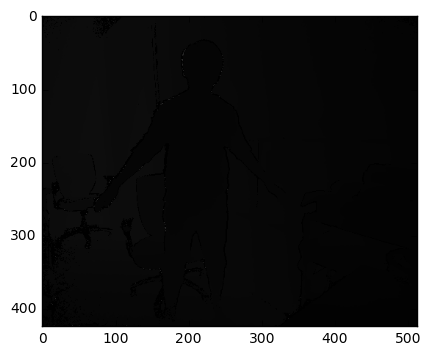

In [5]:
plt.imshow(img)

In [6]:
skeletons = pd.read_json(json_file)
skeleton = skeletons["skeletons"][0]
joints = skeleton["joints"]
pixels = skeleton["pixels"]

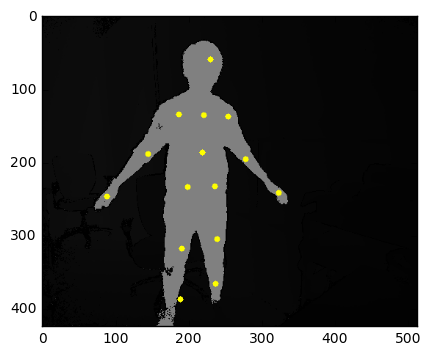

In [7]:
for px in pixels:
    img[px[1], px[0]] = [128, 128, 128]
    
for j in [j["value"] for j in joints]:
    cv2.circle(img, (int(j[0]), int(j[1])), 4, (255, 255, 0), -1)
    
plt.imshow(img)

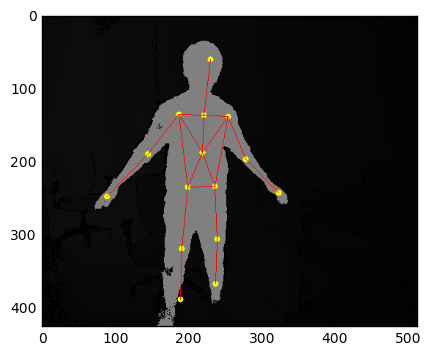

In [8]:
from math import pow

img_skeleton = img.copy()

for bone_type, pairs in joint_pairs.items():
    for pair in pairs:
        j0 = [int(i) for i in [j for j in joints if j["key"] == pair[0]][0]["value"]]
        j1 = [int(i) for i in [j for j in joints if j["key"] == pair[1]][0]["value"]]
        cv2.line(img_skeleton, tuple(j0), tuple(j1), (255, 0, 0))
        
plt.imshow(img_skeleton)

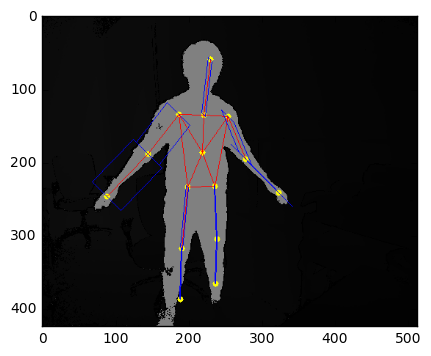

In [9]:
img_segmented = img_skeleton.copy()

for bone_type, pairs in joint_pairs.items():
    if bone_type == BoneType.TORSO:
        continue
    for pair in pairs:
        j0 = [int(i) for i in [j for j in joints if j["key"] == pair[0]][0]["value"]]
        j1 = [int(i) for i in [j for j in joints if j["key"] == pair[1]][0]["value"]]
        grad = (j1[1] - j0[1]) / (j1[0] - j0[0])
        grad_inv = pow(grad, -1)
        a = 20
        j00 = [int(i - a * grad_inv) for i in j0]
        j01 = [int(i + a * grad_inv) for i in j0]
        j10 = [int(i - a * grad_inv) for i in j1]
        j11 = [int(i + a * grad_inv) for i in j1]
        cv2.line(img_segmented, tuple(j00), tuple(j01), (0, 0, 255))
        cv2.line(img_segmented, tuple(j00), tuple(j10), (0, 0, 255))
        cv2.line(img_segmented, tuple(j01), tuple(j11), (0, 0, 255))
        cv2.line(img_segmented, tuple(j10), tuple(j11), (0, 0, 255))
        
plt.imshow(img_segmented)

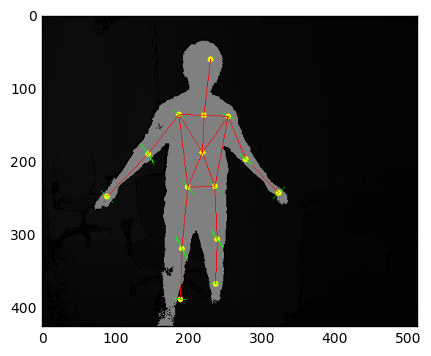

In [10]:
from math import sqrt, pow, atan2, tan

img_segmented2 = img_skeleton.copy()

joint_type_groups = [
    [
        JointType.NECK,
        JointType.LEFT_SHOULDER,
        JointType.LEFT_ELBOW,
        JointType.LEFT_HAND,
    ],
    [
        JointType.LEFT_SHOULDER,
        JointType.LEFT_ELBOW,
        JointType.LEFT_HAND,
        None, 
    ],
    [
        JointType.NECK,
        JointType.RIGHT_SHOULDER,
        JointType.RIGHT_ELBOW,
        JointType.RIGHT_HAND,
    ],
    [
        JointType.RIGHT_SHOULDER,
        JointType.RIGHT_ELBOW,
        JointType.RIGHT_HAND,
        None, 
    ],
    [
        JointType.LEFT_SHOULDER,
        JointType.LEFT_HIP,
        JointType.LEFT_KNEE,
        JointType.LEFT_FOOT,
    ],
    [
        JointType.LEFT_HIP,
        JointType.LEFT_KNEE,
        JointType.LEFT_FOOT,
        None,
    ],
    [
        JointType.RIGHT_SHOULDER,
        JointType.RIGHT_HIP,
        JointType.RIGHT_KNEE,
        JointType.RIGHT_FOOT,
    ],
    [
        JointType.RIGHT_HIP,
        JointType.RIGHT_KNEE,
        JointType.RIGHT_FOOT,
        None,
    ],
]

for joint_types in joint_type_groups:
    points = [[j["value"] for j in joints if j["key"] == t][0] for t in joint_types if t is not None]

    v10 = [points[0][0] - points[1][0], points[0][1] - points[1][1]]
    v12 = [points[2][0] - points[1][0], points[2][1] - points[1][1]]
    v21 = [points[1][0] - points[2][0], points[1][1] - points[2][1]]
    if len(points) == 4:
        v23 = [points[3][0] - points[2][0], points[3][1] - points[2][1]]

    v10_abs = sqrt(pow(v10[0], 2) + pow(v10[1], 2))
    v12_abs = sqrt(pow(v12[0], 2) + pow(v12[1], 2))
    v21_abs = sqrt(pow(v21[0], 2) + pow(v21[1], 2))
    if len(points) == 4:
        v23_abs = sqrt(pow(v23[0], 2) + pow(v23[1], 2))

    a1 = [v12_abs * v10[0] + v10_abs * v12[0], v12_abs * v10[1] + v10_abs * v12[1]]
    a1 = [i / (v10_abs + v12_abs) for i in a1]
    # ここの-1倍がなければ右腕は正常になる（左腕がおかしくなる）
    g1 = (a1[1] - points[1][1]) / (a1[0] - points[1][0])
    
    g2 = 0
    if len(points) == 4:
        a2 = [v23_abs * v21[0] + v21_abs * v23[0], v23_abs * v21[1] + v23_abs * v21[1]]
        a2 = [i / (v21_abs + v23_abs) for i in a2]
        g2 = (a2[1] - points[2][1]) / (a2[0] - points[2][0])
    else: g2 = -pow(v12[1] / v12[0], -1)

    # TODO: 領域中に含まれるpixel数の変化からいい感じのaの値を求める
    a = 8

    j00 = (int(points[1][0] - a), int(points[1][1] - a * g1))
    j01 = (int(points[1][0] + a), int(points[1][1] + a * g1))
    j10 = (int(points[2][0] - a), int(points[2][1] - a * g2))
    j11 = (int(points[2][0] + a), int(points[2][1] + a * g2))

    cv2.line(img_segmented2, j00, j01, (0, 255, 0))
#     cv2.line(img_segmented2, j00, j10, (0, 255, 0))
#     cv2.line(img_segmented2, j01, j11, (0, 255, 0))
    cv2.line(img_segmented2, j10, j11, (0, 255, 0))


plt.imshow(img_segmented2)